### Analysis of symmetric prime number distances and their distribution over n

In [1]:
# external
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
import seaborn as sns
from scipy.stats import gaussian_kde
from scipy.optimize import curve_fit

import sys
sys.path.append('../..')

# custom
from goldbach_conjecture.utils.prime_functions import (
    sieve_of_erathosthenes,
    symmetric_prime_number_distances,
    find_prime_twins,
    prime_twins_in_symmetric_distances,
)


In [2]:
compute_primes = False
compute_distances = True
plot_distances = False
saving_figs = False
lim = 500000
n_lim = int(lim/2)

**load data**

In [3]:
prime_artifacts = {}

if compute_primes:
    primes = sieve_of_erathosthenes(lim, '../../artifacts/primes/prime_100000.npy')
    np.save(f'../../artifacts/primes/prime_{str(lim)}.npy', primes)

else:
    primes = np.load(f'../../artifacts/primes/prime_{str(lim)}.npy')

prime_artifacts['primes'] = primes

**calculate symmetric prime number distances**

In [4]:
n_lim_distances = 50000

if compute_distances:
    distances_to_primes = [symmetric_prime_number_distances(n, prime_artifacts['primes']) for n in range(n_lim_distances)]

    count_distances = [len(dists) for dists in distances_to_primes]
    np.save(f'../../artifacts/primes/count_distances_{str(lim)}.npy', np.array(count_distances))

    min_distances = [min(dists) for dists in distances_to_primes if len(dists) > 0]
    min_distances = [-1, -1] + min_distances
    np.save(f'../../artifacts/primes/min_distances_{str(lim)}.npy', np.array(min_distances))

    max_distances = [max(dists) for dists in distances_to_primes if len(dists) > 0]
    max_distances = [-1, -1] + max_distances
    np.save(f'../../artifacts/primes/max_distances_{str(lim)}.npy', np.array(max_distances))

else: 
    count_distances = list(np.load(f'../../artifacts/primes/count_distances_{str(n_lim_distances)}.npy'))
    min_distances = list(np.load(f'../../artifacts/primes/min_distances_{str(n_lim_distances)}.npy'))
    max_distances = list(np.load(f'../../artifacts/primes/max_distances_{str(n_lim_distances)}.npy'))



#### Plot distribution parameters of symmetric distances

**Plot properties of symmetric distances in separate plots**

Idea to distance plot:

one could define a delta n, normalize the y-range with a min/max and and calculate a kde along the y-axis
-> do a 3d plot of the different lines out of the kde: if the density in high numbers is the same as in low numbers, then the lines should kinda overlap

''

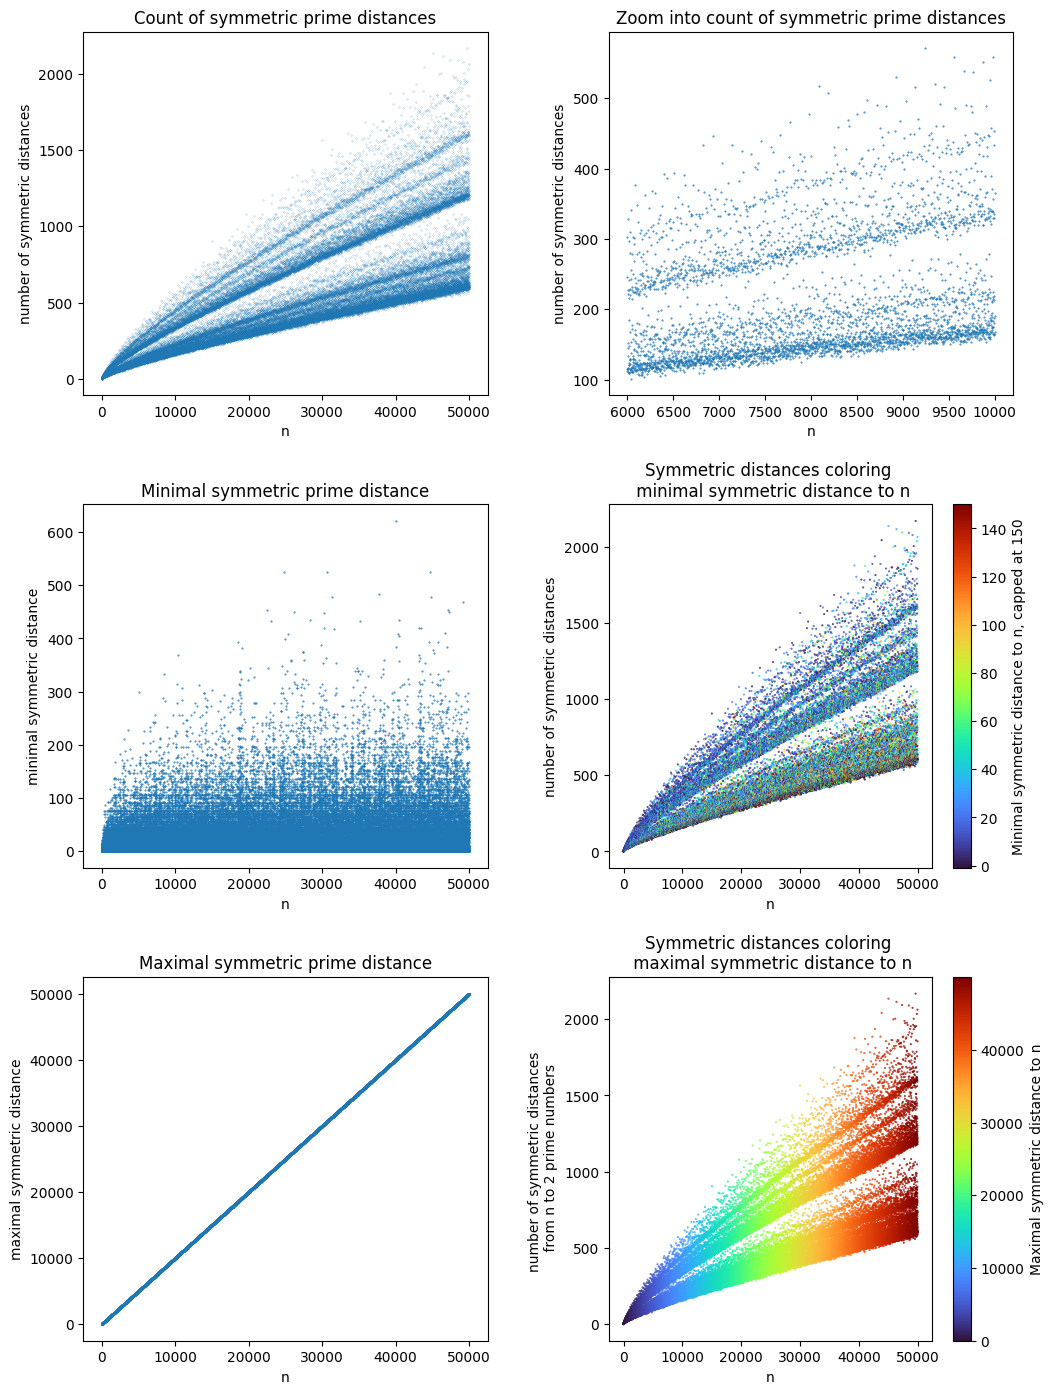

In [100]:
fig, ax = plt.subplots(3,2, figsize=(12,17))


#### count of symmetric distances
# plot counts
ax[0,0].scatter(range(n_lim_distances), count_distances, s=0.02)
ax[0,0].set_xlabel('n')
ax[0,0].set_ylabel('number of symmetric distances')
ax[0,0].set_title('Count of symmetric prime distances')

# zoom into counts
ax[0,1].scatter(range(n_lim_distances)[6000:10000], count_distances[6000:10000], s=0.2)
ax[0,1].set_xlabel('n')
ax[0,1].set_ylabel('number of symmetric distances')
ax[0,1].set_title('Zoom into count of symmetric prime distances')

#### minimum of distribution of symmetric distances

# plot minimal distance per n
ax[1,0].scatter(range(n_lim_distances), min_distances, s=0.2)
ax[1,0].set_xlabel('n')
ax[1,0].set_ylabel('minimal symmetric distance')
ax[1,0].set_title('Minimal symmetric prime distance')

# color plot of minimal distance on symmetric distance plot
p1 = ax[1,1].scatter(range(n_lim_distances), count_distances, c=min_distances, cmap='turbo', vmax=150, s=0.2)
ax[1,1].set_xlabel('n')
ax[1,1].set_ylabel('number of symmetric distances')
ax[1,1].set_title('Symmetric distances coloring \n minimal symmetric distance to n')
cbar = plt.colorbar(p1)
cbar.ax.set_ylabel('Minimal symmetric distance to n, capped at 150')

#### minimum of distribution of symmetric distances

# plot maximal distance per n
ax[2,0].scatter(range(n_lim_distances), max_distances, s=0.2)
ax[2,0].set_xlabel('n')
ax[2,0].set_ylabel('maximal symmetric distance')
ax[2,0].set_title('Maximal symmetric prime distance')

p2 = ax[2,1].scatter(range(n_lim_distances), count_distances, c=max_distances, cmap='turbo', s=0.2)
ax[2,1].set_xlabel('n')
ax[2,1].set_ylabel('number of symmetric distances \n from n to 2 prime numbers')
ax[2,1].set_title('Symmetric distances coloring \n maximal symmetric distance to n')
cbar = plt.colorbar(p2)
cbar.ax.set_ylabel('Maximal symmetric distance to n')

plt.subplots_adjust(wspace=0.3, hspace=0.3)

plt.savefig(f'../../artifacts/plots/symmetric_distance/symmetric_distance_summary.png', bbox_inches='tight', dpi=200) if saving_figs else ''


**Findings**: <br> <br>
symmetric distance plot has an odd regularities: <br>
- there seems to be a **lower threshold for the lowest possible count of symmetric distances** which seems to follow a function  -> we never reach 0
  *---> proving why this has to be true would be proving the Goldbach conjecture*
- **count of symmetric distances is not uniformly dense**: some counts of symmetric distances appear more often, others are less likely, and they seem to follow a distribution
- the lower distribution part for the count of symmetic distances seem to have **higher minimums** for the lowest symmetric distance for any n


#### Understanding the Multi-Modality of the density distribution of the symmetric distance frequency over n 
Why does the density distribution for the frequency of symmetric distances seem bimodal?
- Find a way to visualize bimodality as a histogram (with x-axis being somewhat normalized to n? because the bimodality ranges on y increase with higher n)
- Extract peaks from kde and visualize these peaks across $\delta$ n - try to find fit

**Visualize multi-modality**

In [94]:
def plot_bimodality(
    count_distances: list, 
    n_segments: int, 
    colormap_str: str, 
    xlabel_str: str,
    xlim_tuple: tuple = None, 
) -> None:

    steps = int(len(count_distances)/n_segments)
    
    # color
    cmap = colormaps[colormap_str]
    colors = cmap(np.linspace(0, 1, 100))
    color_steps = int(len(colors)/n_segments)
    
    for i in range(n_segments):
        
        if i < n_segments-1:
            sns.kdeplot(count_distances[i*steps:(i+1)*steps], label=f"{i*steps}<=n<{(i+1)*steps}", color = colors[(i+1)*color_steps])
        else: 
            sns.kdeplot(count_distances[i*steps:-1], label=f"{i*steps}<=n<{len(count_distances)}",  color = colors[-1])

        if xlim_tuple:
            plt.xlim(xlim_tuple)
        plt.xlabel(xlabel_str)
        plt.legend()



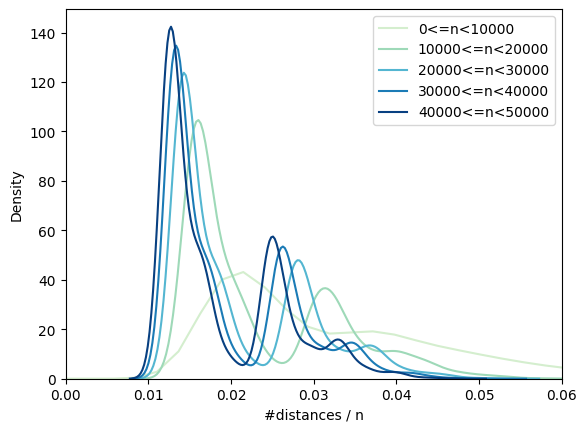

In [95]:
norm_count_distances = [0] + [count / i for i, count in enumerate(count_distances) if i > 0]

plot_bimodality(norm_count_distances, 5, 'GnBu', '#distances / n', (0,0.06))

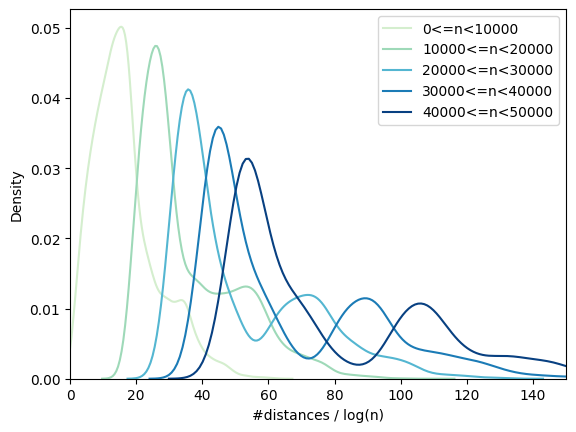

In [96]:
log_count_distances = [0, 0] + [count / np.log(i) for i, count in enumerate(count_distances) if i > 1]

plot_bimodality(log_count_distances, 5, 'GnBu', '#distances / log(n)', (0, 150))

Its very hard to guess the correct transformation / function on how the peaks (#distances) develop with increasing n.

---> Lets calculate the kde, extract the peaks and do a fit on the peaks directly.

**Calculate multi-modal kde & fit peaks of kde**

Extract KDE

In [50]:
steps = 2000 # segment width
n_segments = int(len(count_distances)/steps)
kdes = []

for i in range(n_segments):
    n_min = i*steps
    n_max = (i+1)*steps if i<(n_segments-1) else len(count_distances)-1
    hist_values = count_distances[n_min:n_max]
    kde_grid = np.arange(min(hist_values), max(hist_values))
    kdes.append(
        {'kde_grid': kde_grid, 
         'kde_values': gaussian_kde(hist_values).evaluate(kde_grid), 
         'segment': (n_min, n_max) 
        }
    ) 


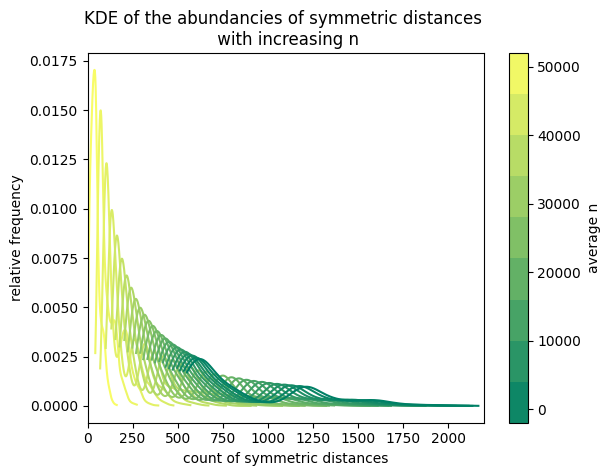

In [70]:
# color
cmap = colormaps['summer']
colors = cmap(np.linspace(0, 1, 100)[::-1])
color_steps = int(len(colors)/len(kdes))
mean_n = []

fig, ax = plt.subplots(1,1)
for i, k in enumerate(kdes):
    #print(k)
    plt.plot(k['kde_grid'], k['kde_values'], color=colors[(i+1)*color_steps-1])
    mean_n.append((k['segment'][1] + k['segment'][0])/2)

plt.xlim(0,2200)
plt.ylabel('relative frequency')
plt.xlabel('count of symmetric distances')
plt.colorbar(plt.cm.ScalarMappable(cmap=cmap), ax=ax, values=mean_n[::3], label='average n')
plt.title('KDE of the abundancies of symmetric distances \n with increasing n')
plt.show()

Find the 3 peaks of each KDE

In [74]:
n_peaks = 3
peaks_array = np.zeros((len(kdes), 3))

for j, k in enumerate(kdes):

    prev_val_increasing = (k['kde_values'] - np.roll(k['kde_values'], 1))>0 # not taken care of ind 0
    next_val_decreasing = (k['kde_values'] - np.roll(k['kde_values'], -1))>0 # not taken care of ind -1

    peak_ind = (prev_val_increasing & next_val_decreasing)
                
    k['kde_peaks'] = k['kde_grid'][peak_ind]
    peaks_array[j, :len(k['kde_grid'][peak_ind])] = np.array(k['kde_grid'][peak_ind])


Plot Peaks

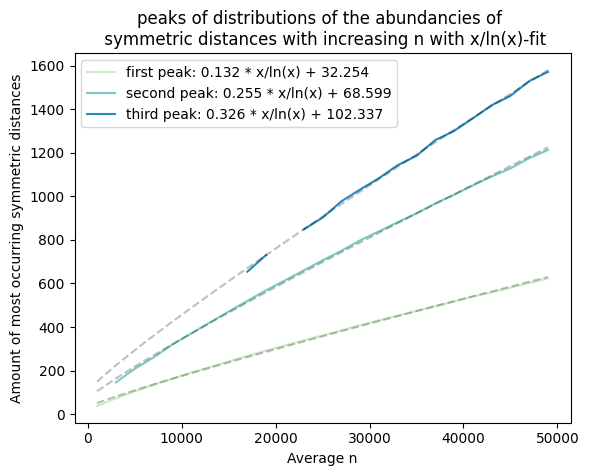

In [150]:
n_mean = np.array([(k['segment'][1] + k['segment'][0])/2 for k in kdes])
peaks_array[peaks_array==0]=np.nan

def fit_peaks(n_means, peaks):

    # fit function
    def func(x, a, b):
        return a * (x / np.log(x)) + b
    
    popt, pcov = curve_fit(func, n_mean, peaks, nan_policy='omit')
    
    return [func(x, popt[0], popt[1]) for x in n_mean], popt

# color
cmap = colormaps['GnBu']
colors = cmap(np.linspace(0, 1, 100))
alpha = 0.25

fit, popt = fit_peaks(n_mean, peaks_array.T[0])
plt.plot(n_mean, peaks_array.T[0], color = colors[25], label='first peak: %5.3f * x/ln(x) + %5.3f' % tuple(popt))
plt.plot(n_mean, fit, '--', color = 'black', alpha=alpha)

fit, popt = fit_peaks(n_mean, peaks_array.T[1])
plt.plot(n_mean, peaks_array.T[1], color = colors[50],label='second peak: %5.3f * x/ln(x) + %5.3f' % tuple(popt))
plt.plot(n_mean, fit, '--', color = 'black', alpha=alpha)

fit, popt = fit_peaks(n_mean, peaks_array.T[2])
plt.plot(n_mean, peaks_array.T[2], color = colors[75],label='third peak: %5.3f * x/ln(x) + %5.3f' % tuple(popt))
plt.plot(n_mean, fit, '--', color = 'black', alpha=alpha)


plt.xlabel('Average n')
plt.ylabel('Amount of most occurring symmetric distances')
plt.title('peaks of distributions of the abundancies of \n symmetric distances with increasing n with x/ln(x)-fit')
plt.legend()


#### Deep dive into individual n and their surrounding primes
- Pick two adjacent n with each one belonging to the different bimodal distributions: understand in detail of how the prime numbers shift relativ to these n so create twice the number of symmetric distances for the next n+1

**Picking adjacent n and n+1 and visualize why n+1 has twice the amount of symmetric distances**

Picking n: n = 1007, n+1 = 1008

Text(0, 0.5, 'number of symmetric distances \n from n to 2 prime numbers')

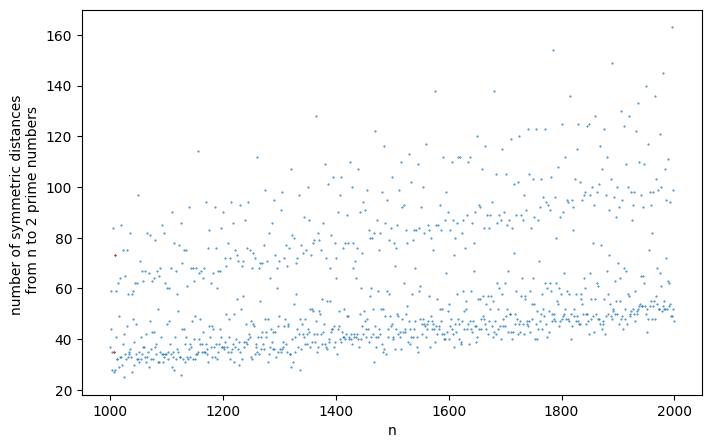

In [29]:
low = 1000
up = 2000

fig, ax = plt.subplots(1,1, figsize=(8,5))
p1 = ax.scatter(range(n_lim_distances)[low:up], count_distances[low:up], s=0.2)
p1 = ax.scatter(range(n_lim_distances)[1007:1009], count_distances[1007:1009], s=0.2, color='r')
ax.set_xlabel('n')
ax.set_ylabel('number of symmetric distances \n from n to 2 prime numbers')

In [6]:
# maybe we can colorcode the primes up until 2014 / 2016, and plot the matching primes around 1007 / 1008

primes_binary = np.zeros(2020)
primes_binary[primes[primes<2020]] = 1

In [7]:
n = 1007

primes_lower_n = primes_binary[:n+1] # including 1007
primes_greater_n = primes_binary[n:2*n+1][::-1]

primes_binary_around_n = np.array([primes_lower_n, primes_greater_n])

# highlighting the symmetric distances
primes_binary_around_n[0][primes_lower_n+primes_greater_n==2] = 2
primes_binary_around_n[1][primes_lower_n+primes_greater_n==2] = 2

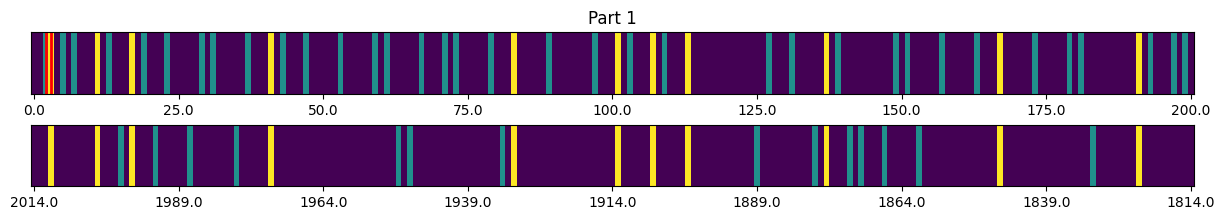

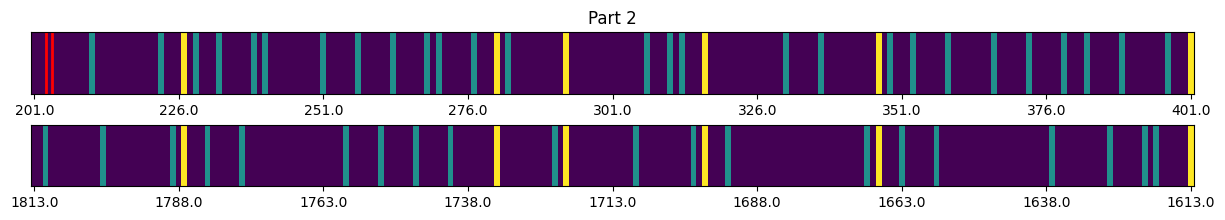

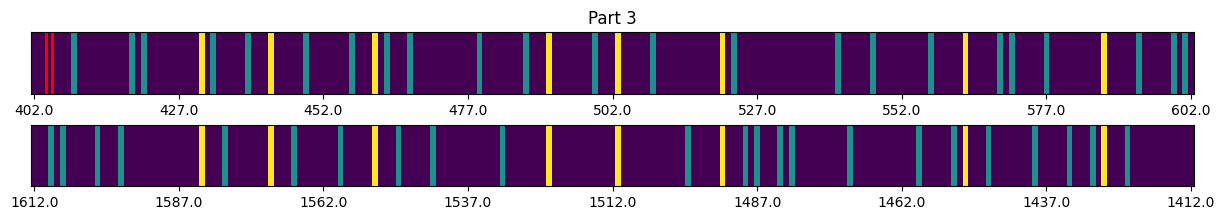

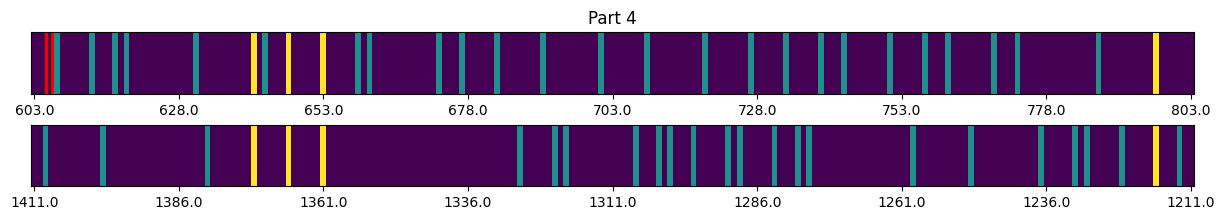

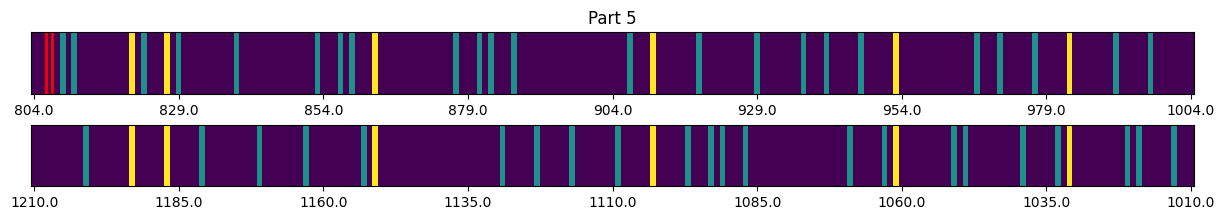

In [26]:
div = 5
breaks = int(primes_binary_around_n.shape[1]/div)

for i in range(div):
    
    fig, ax = plt.subplots(2, 1, figsize=(15, 2))

    if (i+1)*breaks<primes_binary_around_n.shape[1]:
        c1 = ax[0].imshow([primes_binary_around_n[0][i*breaks:(i+1)*breaks]], interpolation='nearest', aspect='auto')
        c2 = ax[1].imshow([primes_binary_around_n[1][i*breaks:(i+1)*breaks]], interpolation='nearest', aspect='auto')
    else:
        c1 = ax[0].imshow([primes_binary_around_n[0][i*breaks:]], interpolation='nearest', aspect='auto')
        c2 = ax[1].imshow([primes_binary_around_n[1][i*breaks:]], interpolation='nearest', aspect='auto')

    c1_xticks  = ax[0].get_xticks()
    c1_xticks = c1_xticks[(c1_xticks>=0) & (c1_xticks<breaks)]
    ax[0].set_xticks(c1_xticks, i*breaks + np.array(c1_xticks))
    
    c2_xticks  = ax[1].get_xticks()
    c2_xticks = c2_xticks[(c2_xticks>=0) & (c2_xticks<breaks)]
    ax[1].set_xticks(c2_xticks, 2*n - i*breaks - np.array(c2_xticks))
    
    ax[0].set_yticks([])
    ax[1].set_yticks([])

    highlight_coords = [(2, -1)]  # Example coordinates

    # Add rectangles to highlight selected squares
    for (ii, jj) in highlight_coords:
        rect = plt.Rectangle((ii, jj), 1, 2, linewidth=2, edgecolor="red", facecolor="none")
        ax[0].add_patch(rect)

    plt.subplots_adjust(hspace=0.5)

    ax[0].set_title(f"Part {i+1}")

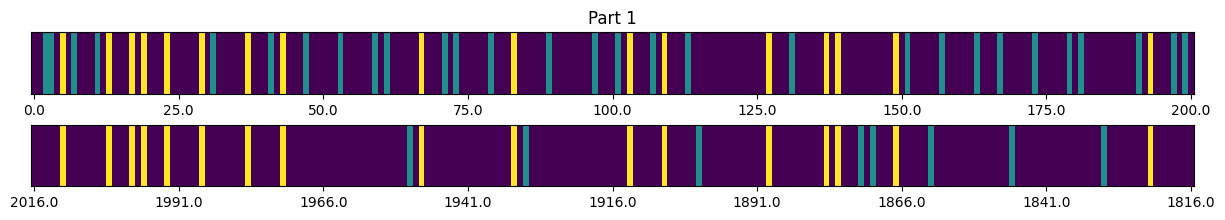

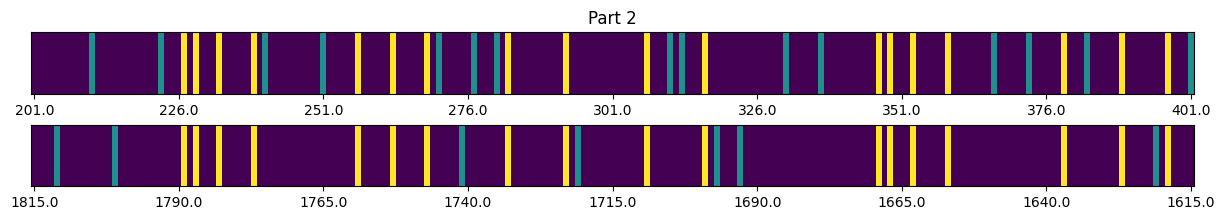

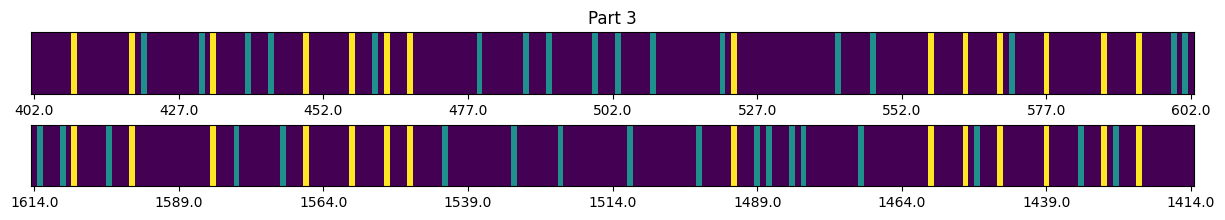

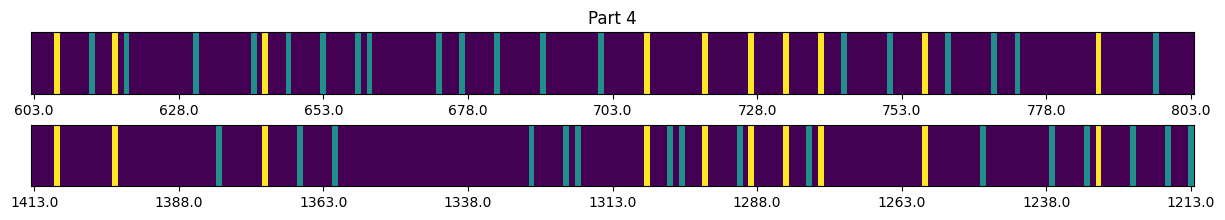

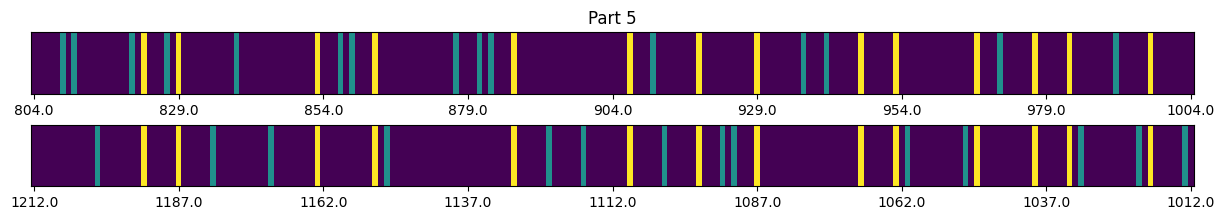

In [99]:
n = 1008

primes_lower_n = primes_binary[:n+1] # including 1007
primes_greater_n = primes_binary[n:2*n+1][::-1]

primes_binary_around_n = np.array([primes_lower_n, primes_greater_n])

# highlighting the symmetric distances
primes_binary_around_n[0][primes_lower_n+primes_greater_n==2] = 2
primes_binary_around_n[1][primes_lower_n+primes_greater_n==2] = 2

div = 5
breaks = int(primes_binary_around_n.shape[1]/div)

for i in range(div):
    
    fig, ax = plt.subplots(2, 1, figsize=(15, 2))

    if (i+1)*breaks<primes_binary_around_n.shape[1]:
        c1 = ax[0].imshow([primes_binary_around_n[0][i*breaks:(i+1)*breaks]], interpolation='nearest', aspect='auto')
        c2 = ax[1].imshow([primes_binary_around_n[1][i*breaks:(i+1)*breaks]], interpolation='nearest', aspect='auto')
    else:
        c1 = ax[0].imshow([primes_binary_around_n[0][i*breaks:]], interpolation='nearest', aspect='auto')
        c2 = ax[1].imshow([primes_binary_around_n[1][i*breaks:]], interpolation='nearest', aspect='auto')

    c1_xticks  = ax[0].get_xticks()
    c1_xticks = c1_xticks[(c1_xticks>=0) & (c1_xticks<breaks)]
    ax[0].set_xticks(c1_xticks, i*breaks + np.array(c1_xticks))
    
    c2_xticks  = ax[1].get_xticks()
    c2_xticks = c2_xticks[(c2_xticks>=0) & (c2_xticks<breaks)]
    ax[1].set_xticks(c2_xticks, 2*n - i*breaks - np.array(c2_xticks))
    
    
    ax[0].set_yticks([])
    ax[1].set_yticks([])
    
    plt.subplots_adjust(hspace=0.5)

    ax[0].set_title(f"Part {i+1}")


(array([2., 1., 1., 3., 0., 0., 3., 0., 2., 2., 2., 3., 1., 1., 2., 1., 2.,
        3., 2., 4.]),
 array([  24.,   73.,  122.,  171.,  220.,  269.,  318.,  367.,  416.,
         465.,  514.,  563.,  612.,  661.,  710.,  759.,  808.,  857.,
         906.,  955., 1004.]),
 <BarContainer object of 20 artists>)

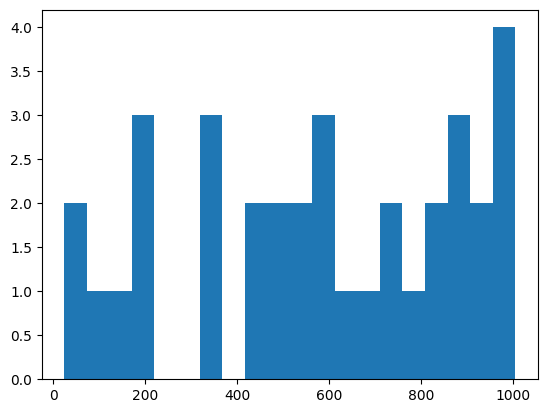

In [33]:
# we have here now 2 examples of the lower and upper curve for prime distances. any differences in distribution?
plt.hist(distances_to_primes[1007], bins=20)

(array([5., 4., 3., 2., 2., 5., 0., 3., 6., 1., 3., 4., 5., 4., 5., 4., 1.,
        5., 3., 8.]),
 array([  11. ,   60.6,  110.2,  159.8,  209.4,  259. ,  308.6,  358.2,
         407.8,  457.4,  507. ,  556.6,  606.2,  655.8,  705.4,  755. ,
         804.6,  854.2,  903.8,  953.4, 1003. ]),
 <BarContainer object of 20 artists>)

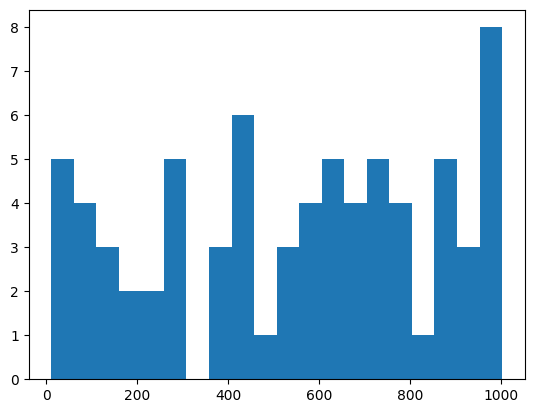

In [36]:
plt.hist(distances_to_primes[1008], bins=20)

#### Do prime twins have anything to do with the regularities in the symmetric distances?

**How would the symmetric distances look like with only prime twin pairs?** <br>
-> if they reveal the same pattern in the symmetric distances, then this would mean that they are super important for this distribution

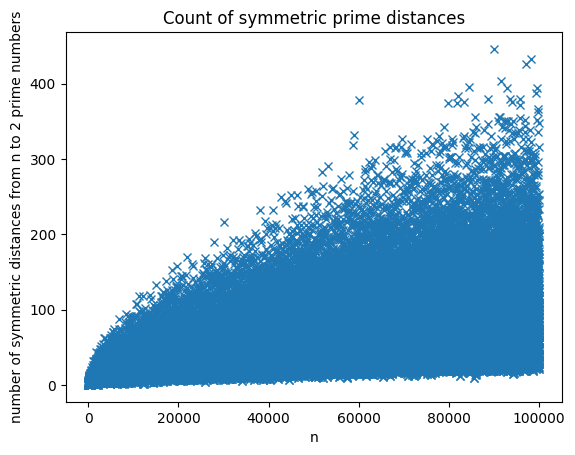

In [14]:
# Calculate prime twins
prime_twins = find_prime_twins(primes)

# plot distances only with prime twins
# -> plot without any correlation
n_twin_lim = 100000
distances_to_twin_primes = [symmetric_prime_number_distances(n, prime_twins) for n in range(n_twin_lim)]

count_twin_distances = [len(dists) for dists in distances_to_twin_primes]
plt.plot(range(n_twin_lim), count_twin_distances, 'x')
plt.xlabel('n')
plt.ylabel('number of symmetric distances from n to 2 prime numbers')
plt.title('Count of symmetric prime distances')
plt.savefig(f'artifacts/plots/prime_twins/n_distances_only_twins.png') if saving_figs else None

**Are the individual lines in the symmetric distance plot connected with the density of prime twins?** 

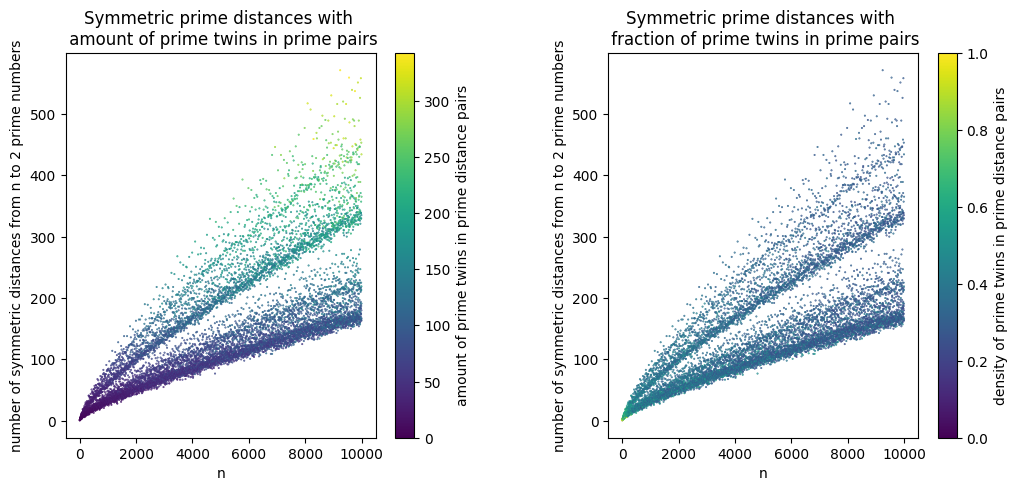

In [17]:
try:
    prime_twin_abundance = np.load(f'../../artifacts/primes/prime_twin_abundance_in_i_10000.npy', allow_pickle=True)
except FileNotFoundError:
    prime_twin_abundance = [prime_twins_in_symmetric_distances(n, distances_to_primes[:2*n], prime_twins[prime_twins<2*n])
                        for n in range(10000)]
    prime_twin_abundance = np.array(prime_twin_abundance)
    prime_twin_abundance = prime_twin_abundance.T
    np.save(f'../../artifacts/primes/prime_twin_abundance_in_i_10000.npy', prime_twin_abundance)

fig, ax = plt.subplots(1,2, figsize=(12,5))
p1 = ax[0].scatter(np.arange(10000), count_distances[:10000], c=prime_twin_abundance[0], s=0.2)
ax[0].set_xlabel('n')
ax[0].set_ylabel('number of symmetric distances from n to 2 prime numbers')
ax[0].set_title('Symmetric prime distances with \n amount of prime twins in prime pairs')
cbar = plt.colorbar(p1)
cbar.ax.set_ylabel('amount of prime twins in prime distance pairs')

p2 = ax[1].scatter(range(10000), count_distances[:10000], c=prime_twin_abundance[1], s=0.2)
ax[1].set_xlabel('n')
ax[1].set_ylabel('number of symmetric distances from n to 2 prime numbers')
ax[1].set_title('Symmetric prime distances with \n fraction of prime twins in prime pairs')
cbar = plt.colorbar(p2)
cbar.ax.set_ylabel('density of prime twins in prime distance pairs')

plt.subplots_adjust(wspace=0.4)
plt.savefig(f'artifacts/plots/prime_twins/n_distances_twin_abundance.png') if saving_figs else None
plt.show()